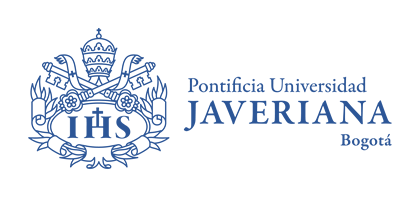

# Aprendizaje profundo - Taller 2
Este notebook tiene como objetivo familiarizar al estudiante con un ambiente de aprendizaje por refuerzo bajo el API de OpenAI Gym



En el segundo taller del curso se utilizará el framework OpenAI Gym y Tensorflow Agents para crear una red neuronal profunda que resuelva un cubo de rubik de 2x2x2 utilizando el gimnasio RubiksCubeGym disponible [en github siguiendo este link](https://github.com/DoubleGremlin181/RubiksCubeGym)



Este notebook utiliza instrucciones del tutorial **Train a Deep Q Network with TF-Agents** disponible en este [link](https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=pmDI-h7cI0tI)  


## Setup
Se instalan y se importan las librerías necesarias para el ejercicio

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents
!pip install rubiks-cube-gym

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:14 http://ppa.launchpad.net/deadsnake

In [ ]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common

In [ ]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Exploración del ambiente

En las siguientes celdas se explora el ambiente rubiks cube, cómo se visualiza el cubo y las acciones que se pueden aplicar al cubo

In [ ]:
env_name='rubiks-cube-222-v0'

In [ ]:
import rubiks_cube_gym

**Cuidado:**

Este API hace uso de un archivo pickle que descarga desde un bucket de google  ``rubiks_cube_222_states_FRU.pickle``, esta descarga se hace si no encuentra el archivo en el el siguiente path:

``\usr\local\lib\python3.7\dist-packages\rubiks_cube_gym\envs\``

Se sugiere copiar y subir el archivo directamente desde brightspace  para no agotar el presupuesto del bucket del desarrollador de la librería.

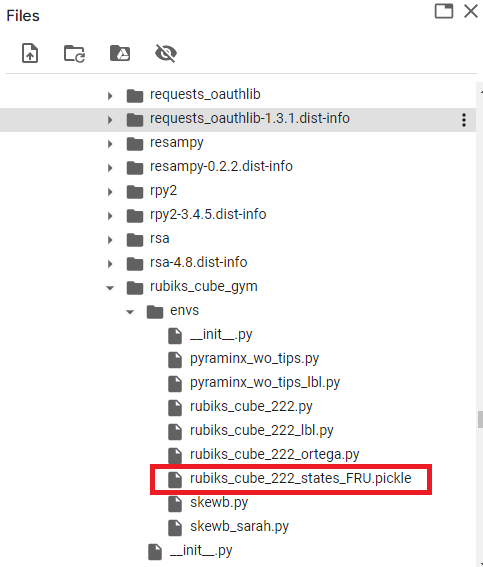

In [ ]:
# En este punto se realiza la descarga
env = suite_gym.load(env_name)


In [ ]:
env.reset()

TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array(2802266),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})

Una vez cargado el gimnasio, se puede visualizar el estado del cubo, el cubo inicia con un estado aleatorio

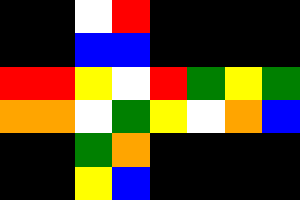

In [ ]:
# Visualización como imagen del entorno
PIL.Image.fromarray(env.render()).resize((300,200),PIL.Image.BOX)

In [ ]:
# Visualización del entorno como string de resumen
env.cube_reduced 

'WRBBRRYWRGYGOOWGYWOBGOYB'

In [ ]:
# Visualización del entorno como arreglo RGB
env.render()

array([[[  0,   0,   0],
        [  0,   0,   0],
        [255, 255, 255],
        [255,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0, 255],
        [  0,   0, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255,   0,   0],
        [255,   0,   0],
        [255, 255,   0],
        [255, 255, 255],
        [255,   0,   0],
        [  0, 128,   0],
        [255, 255,   0],
        [  0, 128,   0]],

       [[255, 165,   0],
        [255, 165,   0],
        [255, 255, 255],
        [  0, 128,   0],
        [255, 255,   0],
        [255, 255, 255],
        [255, 165,   0],
        [  0,   0, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0, 128,   0],
        [255, 165,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0

El cubo se puede inicializar en alguna configuración por defecto también utilizando la notación [WCA disponible en este link](https://www.worldcubeassociation.org/regulations/#article-12-notation)

El método de reset con parámetros no esta disponible en el api de tf_agents, por lo que se inicializa el ambiente en este caso utilizando gym

In [ ]:
import gym
env_gym = gym.make(env_name)  
env_gym.reset(scramble="R U R' U' R' F R2 U' R' U' R U R' F'") 
env_gym.cube_reduced


'WWWWOOGRBGRBOOGGRRBBYYYY'

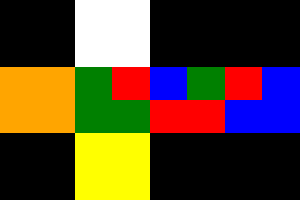

In [ ]:
PIL.Image.fromarray(env_gym.render(mode='rgb_array')).resize((300,200),PIL.Image.BOX)

In [ ]:
# Ambiente con cubo ordenado
import gym
env_gym_ordered = gym.make(env_name)  
env_gym_ordered.reset(scramble="R R'") 
env_gym_ordered.cube_reduced

'WWWWOOGGRRBBOOGGRRBBYYYY'

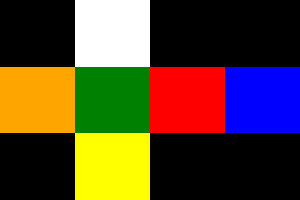

In [ ]:
PIL.Image.fromarray(env_gym_ordered.render(mode='rgb_array')).resize((300,200),PIL.Image.BOX)

## Acciones, espacio de observación y recompensas en tf-agents

El método `time_step_spec()`retorna la especificación del ambiente para avanzar un paso en el tiempo el ambiente.

`observation` indica las posibles combinaciones del cubo que existen: 3674160



In [ ]:
env.time_step_spec()

TimeStep(
{'discount': BoundedArraySpec(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0),
 'observation': BoundedArraySpec(shape=(), dtype=dtype('int64'), name='observation', minimum=0, maximum=3674159),
 'reward': ArraySpec(shape=(), dtype=dtype('float32'), name='reward'),
 'step_type': ArraySpec(shape=(), dtype=dtype('int32'), name='step_type')})

In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='observation', minimum=0, maximum=3674159)


`reward` indica la configuración de la recompensa, en este caso es un float

In [ ]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


El método `action_spec()` retorna las acciones válidas sobre el ambiente. En este caso se tienen 3 acciones que rotar 90 grados en sentido de las agujas del reloj la siguiente superficie del cubo:

*   0 indica girar la cara frontal del cubo
*   1 indica girar la cara derecha del cubo
*   2 indica girar la cara superior del cubo



In [ ]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)


Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array(1580625),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})


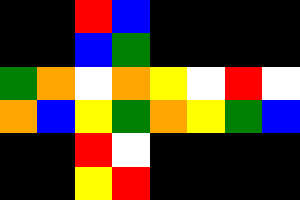

In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)
PIL.Image.fromarray(env.render()).resize((300,200),PIL.Image.BOX)


In [ ]:
env.cube_reduced


'RBBGGOWOYWRWOBYGOYGBRWYR'

In [ ]:
action = np.array(1, dtype=np.int32)
next_time_step = env.step(action)

print('Next time step:')
print(next_time_step)

Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array(2687233),
 'reward': array(-1., dtype=float32),
 'step_type': array(1, dtype=int32)})


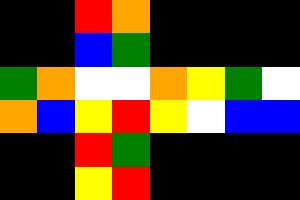

In [ ]:
PIL.Image.fromarray(env.render()).resize((300,200),PIL.Image.BOX)

In [ ]:
env.cube_reduced

'ROBGGOWWOYGWOBYRYWBBRGYR'

In [ ]:
action = np.array(0, dtype=np.int32)
next_time_step = env.step(action)

print('Next time step:')
print(next_time_step)

Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array(2205267),
 'reward': array(-1., dtype=float32),
 'step_type': array(1, dtype=int32)})


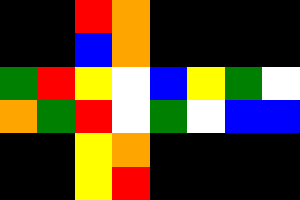

In [ ]:
PIL.Image.fromarray(env.render()).resize((300,200),PIL.Image.BOX)

In [ ]:
action = np.array(0, dtype=np.int32)
next_time_step = env.step(action)

print('Next time step:')
print(next_time_step)

Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array(507120),
 'reward': array(-1., dtype=float32),
 'step_type': array(1, dtype=int32)})


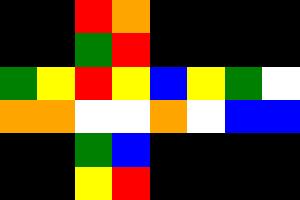

In [ ]:
PIL.Image.fromarray(env.render()).resize((300,200),PIL.Image.BOX)

Note que la recomensa para los pasos dados con las acciones es -1, esto se debe a que el ambiente por defecto retorna -1 a menos que el cubo este completamente ordenado. Revise el siguiente [link](https://github.com/DoubleGremlin181/RubiksCubeGym/blob/master/rubiks_cube_gym/envs/rubiks_cube_222.py#L105) en la función `reward(self,action)` del ambiente.

 

## Extendiendo el ambiente por defecto para incluir una función de recompensa propia

Para extender el ambiente por defecto se debe extender la clase  `RubiksCube222Env` y reimplementar el método `reward(self,action)` 



In [ ]:
from rubiks_cube_gym.envs.rubiks_cube_222 import  RubiksCube222Env

Se crea una clase nueva que retorna una recompensa proporcional al número de casillas correctas en el cubo.

In [ ]:
class NaiveRubiksCube222(RubiksCube222Env):
  solved="WWWWOOGGRRBBOOGGRRBBYYYY"
  def __init__(self):
        super(NaiveRubiksCube222, self).__init__()

  def reward(self):
    
    if self.cube_reduced == self.solved:
      return 100,True
    reward=0  
    for i in range(0,len(self.cube_reduced)):
      reward+=self.solved[i]==self.cube_reduced[i]
    return reward, False

from gym.envs.registration import register

register(
    id='naive-rubiks-cube-222-v0',
    entry_point='__main__:NaiveRubiksCube222',
    max_episode_steps=250,
)


In [ ]:
env_naive = suite_gym.load('naive-rubiks-cube-222-v0')

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array(1709868),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})


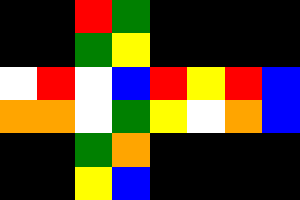

In [ ]:
time_step = env_naive.reset()
print('Time step:')
print(time_step)
PIL.Image.fromarray(env_naive.render()).resize((300,200),PIL.Image.BOX)

In [ ]:
action = np.array(1, dtype=np.int32)
next_time_step = env_naive.step(action)

print('Next time step:')
print(next_time_step)

Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array(1665219),
 'reward': array(6., dtype=float32),
 'step_type': array(1, dtype=int32)})


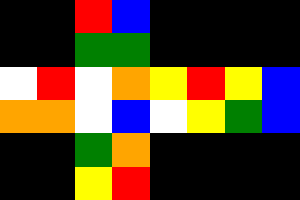

In [ ]:
PIL.Image.fromarray(env_naive.render()).resize((300,200),PIL.Image.BOX)

## Entrenamiento y ajuste de redes neuronales profundas con el agente

Para continuar con el taller, revise el notebook **Train a Deep Q Network with TF-Agents** disponible en este [link](https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb#scrollTo=pmDI-h7cI0tI). Allí se muestra como crear un agente de TensorFlow a partir de un gimnasio de OpenAI gym, el entrenamiento y test de una red Deep Q Network. 

Se espera que complete los siguientes puntos:

1. **[30%]** Extensión de la recompensa del ambiente del gimnasio para resolver el problema. (Se evalúa sobre el notebook o notebooks entregados, no olvide añadir celdas de texto para explicar y documentar su código) 
2. **[35%]** Plantear una red Deep-Q network para resolver el problema. Esto incluye experimentar con diferentes arquitecturas y factores de descuento para la red del agente. Pruebe el desempeño de cada agente en términos de la recompensa promedio obtenida. (Se evalúa sobre el notebook o notebooks entregados, no olvide añadir celdas de texto para explicar y documentar su código)
3. **[35%]** Informe de taller: Realice un informe del taller en el que documente la función de recompensa escogida, la experimentación realizada sobre la red Deep Q network y los resultados obtenidos. No olvide colocar sus conclusiones: ¿Qué aprendió con este taller? ¿Qué cosas funcionaron bien? ¿Qué cosas no funcionaron bien?  

### Lo que su grupo debe entregar: 

Archivo zip que contenga:

Informe, nombrado Informe-taller2.pdf, en formato IEEE transactions on artficial intelligence con lo solicitado en el punto 3. Límite de 10 páginas que no incluyen la bibliografía. 

Carpeta src con notebook o notebooks desarrollados para resolver el problema 

Archivo readme.txt con los nombres de los integrantes del grupo 


 

